In [0]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [0]:
!pip install PyDrive
!pip install geopandas
import re

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from geopy.geocoders import Nominatim
from google.colab import files
import io
import plotly.graph_objects as go
import seaborn as sns

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#idf = '1PN6TbhTwwl-hVII3P89IMbs1ashJ7BYz'
idf = '1QQ7k1Y5RvL0ZcnQuTVg0rHU6O5AK81zQ'
downloaded = drive.CreateFile({'id':idf})   # replace the id with id of file you want to access
downloaded.GetContentFile('flights.parquet') 
# Fuente del dataset: https://www.kaggle.com/divyansh22/flight-delay-prediction

In [0]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd
from pyspark.sql import SQLContext, SparkSession
from collections import Counter
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

Trabajo Practico

In [0]:
uploaded=files.upload()

Saving traintp.csv to traintp.csv
Saving tweets_with_clean_location.csv to tweets_with_clean_location.csv
Saving tweets_with_my_clean_location.csv to tweets_with_my_clean_location.csv


Obtencion Del CSV FREE DE NANO : Es funcion es para limpiar lo mas que se pueda aquellas Locaciones no validas

In [0]:
def quitaNoAlfaNum(texto):
  words=re.compile(r'\W+', re.UNICODE).split(texto)
  word_total=" "
  for word in words:
   word_total=word_total + " " + word
  return word_total

In [186]:
twiter=pd.read_csv(io.BytesIO(uploaded["traintp.csv"]))
twiter["location_isnull"]=twiter.location.isnull()
twiter["location_free"]=twiter.loc[twiter.location_isnull == False].location.transform(quitaNoAlfaNum)
twiter

,id,keyword,location,text,target,location_isnull,location_free
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,True,NaN
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,True,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,True,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,True,NaN
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,True,NaN
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,True,NaN
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,True,NaN
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,True,NaN
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,True,NaN


# Obtencion del Data Frame con Country - City - Longitude - Latitude

In [0]:
#Esta funcion es para obtener los datos de loas locaciones de Data Frame
geolocator = Nominatim(user_agent="orga_datos")
def getGeoData(x):
    l = geolocator.geocode(x, timeout=20)
    if l == None:
       return (None, None, None)
    return ([l.address, l.latitude, l.longitude])

Aca creo la columna address_latitude_longitude del data frame esta linea demora unos 40 min

In [0]:
#twiter["address_latitude_longitude"] = twiter.loc[(twiter.location_isnull == False)&(twiter.location_free.isnull() == False )].location_free.transform(lambda x: getGeoData(x))

In [0]:
twiter_my=twiter

Obtengo las latidudes y longitudes 

In [0]:
def get_latitude(x):
  latidude = x[1]
  return latidude
def get_longitude(x):
  longitude = x[2]
  return longitude

In [249]:
twiter_my["latitude"]=twiter_my.loc[(twiter_my.location_isnull == False)&(twiter_my.location_free.isnull() == False )].address_latitude_longitude.transform(get_latitude)
twiter_my["longitude"]=twiter_my.loc[(twiter_my.location_isnull == False)&(twiter_my.location_free.isnull() == False )].address_latitude_longitude.transform(get_longitude)
twiter_my.loc[(twiter_my.location_isnull == False)&(twiter_my.location_free.isnull() == False )].head(3)

,id,keyword,location,text,target,location_isnull,location_free,address_latitude_longitude,latitude,longitude,city,country
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,False,Birmingham,"[Birmingham, West Midlands Combined Authority,...",52.479699,-1.902691,,
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,False,Est September 2012 Bristol,"(None, None, None)",NaN,NaN,,
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,False,AFRICA,"[Africa, 11.5024338, 17.7578122]",11.502434,17.757812,,


Obtengo Country y City

In [0]:
def get_country(x):
  if x[0] == None:
    return None
  country=x[0].split(",")[-1]
  return country


In [0]:
def get_city(x):
  if x[0] == None:
    return None
  city=x[0].split(",")[0]
  return city

In [0]:
twiter_my["city"]=twiter_my.loc[(twiter_my.location_isnull == False)&(twiter_my.location_free.isnull() == False )].address_latitude_longitude.transform(get_city)
twiter_my["country"]=twiter_my.loc[(twiter_my.location_isnull == False)&(twiter_my.location_free.isnull() == False )].address_latitude_longitude.transform(get_country)

In [269]:
twiter_my.loc[(twiter_my.location_isnull == False)&(twiter_my.location_free.isnull() == False )].head(3)

,id,keyword,location,text,target,location_isnull,location_free,address_latitude_longitude,latitude,longitude,city,country
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,False,Birmingham,"[Birmingham, West Midlands Combined Authority,...",52.479699,-1.902691,Birmingham,United Kingdom
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,False,Est September 2012 Bristol,"(None, None, None)",NaN,NaN,None,None
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,False,AFRICA,"[Africa, 11.5024338, 17.7578122]",11.502434,17.757812,Africa,Africa


Exporto DF A CSV

In [0]:
twiter_my.to_csv('twiter_with_data_location.csv') 
files.download("twiter_with_data_location.csv")

In [0]:
#tweets_with_clean_location=pd.read_csv(io.BytesIO(uploaded["tweets_with_clean_location.csv"]))
#tweets_with_clean_location.head(3)

Bool que me indica si algun campo de la locacion en nula para poder manejar el erro del geopandas

In [0]:
twiter_my["locacion_isnull"]=twiter_my.location.isnull()
#tweets_with_clean_location.head(5)

Calculo la longitud de cada texto

In [281]:
twiter_my["log_text"]=twiter_my.loc[twiter_my.text.isnull()==False].text.transform(len)
twiter_my.head(2)

,id,keyword,location,text,target,location_isnull,location_free,address_latitude_longitude,latitude,longitude,city,country,locacion_isnull,log_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,True,NaN,NaN,NaN,NaN,NaN,NaN,True,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,True,NaN,NaN,NaN,NaN,NaN,NaN,True,38


Veo el promedio de las longitudes por ciudad

1.   localizo aquellas direcciones coon locaciones
2.   filtro aquellas ciudades no nulas





In [282]:
country_grouped=twiter_my.loc[(twiter_my.locacion_isnull == False)\
&(twiter_my.country.isnull()==False)].groupby("country").agg({"log_text":["mean","max","min"],"text":["count"]})
country_grouped.head(3)

log_text            text
                  mean  max  min count
country                               
 Argentina  101.416667  140    8    12
 Armenia    118.000000  118  118     1
 Australia  106.931373  142   33   102

In [0]:
level0=country_grouped.columns.get_level_values(0)
level1=country_grouped.columns.get_level_values(1)
country_grouped.columns=level0 + "_" + level1
country_grouped.reset_index(inplace=True)

In [284]:
country_grouped_top10=country_grouped.sort_values(by=['text_count'],ascending=False).head(10)
country_grouped_top10

,country,log_text_mean,log_text_max,log_text_min,text_count
84,United States of America,103.267895,147,11,1900
83,United Kingdom,103.494033,152,12,419
10,Canada,103.204444,144,24,225
157,United States,106.128655,145,24,171
28,India,107.963964,146,30,111
2,Australia,106.931373,142,33,102
156,United Kingdom,109.680851,140,53,47
24,France,95.697674,143,33,43
56,Philippines,109.692308,148,22,39
51,Nigeria,107.684211,138,35,38


In [285]:
twiter_principal=twiter_my.loc[(twiter_my.locacion_isnull == False)\
&(twiter_my.country.isnull()==False)]
twiter_principal.loc[(twiter_principal["country"].str.contains("United States of America"))].head(2)

,id,keyword,location,text,target,location_isnull,location_free,address_latitude_longitude,latitude,longitude,city,country,locacion_isnull,log_text
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,False,Philadelphia PA,"[Philadelphia, Philadelphia County, Pennsylvan...",39.952724,-75.163526,Philadelphia,United States of America,False,34
46,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfire...,1,False,GREENSBORO NORTH CAROLINA,"[Greensboro, Guilford County, North Carolina, ...",36.072635,-79.791975,Greensboro,United States of America,False,97


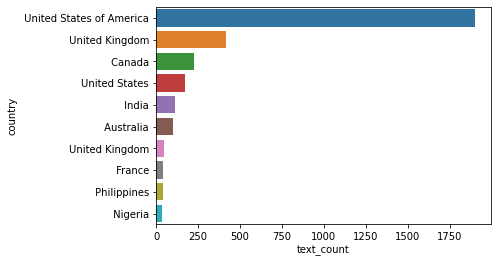

In [286]:
sns.barplot(x="text_count", y="country", data=country_grouped_top10)

In [287]:
fig = go.Figure()
tweets_with_clean_location_with_country=twiter_my.loc[(twiter_my.locacion_isnull == False)\
&(tweets_with_clean_location.country.isnull()==False)]
# Recorremos los datos del archivo csv y extraemos sus coordenadas,
# etiquetas a mostrar y especificamos características del marcador
for i in tweets_with_clean_location_with_country:
    fig.add_trace(go.Scattergeo(
            lon = tweets_with_clean_location_with_country['longitude'],
            lat = tweets_with_clean_location_with_country['latitude'],
            text = tweets_with_clean_location_with_country['country'],
            marker = dict(
                size = 1,
                color = 'red',
                line_color='white',
                line_width=0.5,
                sizemode = 'area'
        )))
 
# Establecemos las características del mapa base, el título y opciones
# de leyenda, así como la propia proyección del mapa.
fig.update_layout(
    title_text = 'Ucicacion de los twiter',
    showlegend = False,
    geo = dict(
        scope='world',
        resolution=110,
        projection_type='mollweide',
        showcoastlines=True,
        showocean=True,
        oceancolor='#132630',
        lakecolor='#132630',
        coastlinecolor='#224354',
        landcolor='#224354',
    )
)
 
# Mostramos la figura creada con las características dadas
fig.show()

Palabras mas frecuentes que apareces en los textos por locacion

In [288]:
twiter_my.loc[twiter_my.locacion_isnull==False].text.value_counts().head(10)

#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_    6
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4          4
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        4
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                 3
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect      3
@spinningbot Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.                                           3
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM                                                                

In [0]:
def contadorDePalabras(text):
  listaPalabras = text.split()
  #for w in listaPalabras :
  #frecuenciaPalab = [listaPalabras.count(w) for w in listaPalabras]
  #lista=list(zip(listaPalabras, frecuenciaPalab))
  #return lista 
  counts = Counter(listaPalabras).most_common(10)
  return counts


In [297]:
tweets_with_clean_location_words_total_for_country=twiter_my.loc[twiter_my.locacion_isnull==False].groupby("country").agg({"text":"sum"})
tweets_with_clean_location_words_total_for_country

,text
country,
Argentina,*se pone a cantar crying lightning*MH370: Inta...
Armenia,New Mad Max Screenshots Show Off a Lovely Dust...
Australia,Arsonists being blamed for a blaze at a plasti...
Bangladesh,Army sources say 12 persons on board including...
Barbados,I Pledge Allegiance To The P.O.P.E. And The Bu...
...,...
ประเทศไทย,@SapphireScallop Destroy oppa image? Oops! The...
ປະເທດລາວ,[Comment] Deaths of older children: what do th...
中国,#hot Funtenna: hijacking computers to send da...


In [0]:
level0=tweets_with_clean_location_words_total_for_country.columns.get_level_values(0)
tweets_with_clean_location_words_total_for_country.columns= "_" + level0
tweets_with_clean_location_words_total_for_country.reset_index(inplace=True)

In [299]:
tweets_with_clean_location_words_total_for_country._text.transform(contadorDePalabras)

0      [(of, 5), (to, 4), (the, 3), (a, 2), (and, 2),...
1      [(New, 1), (Mad, 1), (Max, 1), (Screenshots, 1...
2      [(the, 44), (of, 31), (to, 26), (a, 22), (in, ...
3      [(of, 2), (his, 2), (for, 2), (Army, 1), (sour...
4      [(The, 4), (Pledge, 2), (Allegiance, 2), (To, ...
                             ...                        
180    [(for, 2), (@SapphireScallop, 1), (Destroy, 1)...
181    [(the, 4), (of, 3), (by, 2), (in, 2), (to, 2),...
182    [(in, 6), (#prebreak, 5), (to, 4), (#best#hot,...
183    [(to, 4), (in, 3), (of, 3), (he, 2), (#prebrea...
184    [(@realDonaldTrump, 1), (to, 1), (obliterate, ...
Name: _text, Length: 185, dtype: object

In [300]:
tweets_with_clean_location_words=tweets_with_clean_location
tweets_with_clean_location_words["words_count"]=tweets_with_clean_location_words.loc[tweets_with_clean_location_words.locacion_isnull==False].text.transform(contadorDePalabras)
tweets_with_clean_location_words.loc[tweets_with_clean_location_words.locacion_isnull==False].head(3)

,Unnamed: 0,id,keyword,location,text,target,address_latitude_longitude,city,country,latitude,longitude,locacion_isnull,log_text,words_count
31,31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,"('Birmingham, West Midlands Combined Authority...",Birmingham,United Kingdom,52.479699,-1.902691,False,55,"[(@bbcmtd, 1), (Wholesale, 1), (Markets, 1), (..."
32,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,"(None, None, None)",NaN,NaN,NaN,NaN,False,67,"[(We, 1), (always, 1), (try, 1), (to, 1), (bri..."
33,33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,"('Africa', 11.5024338, 17.7578122)",NaN,NaN,11.502434,17.757812,False,82,"[(#AFRICANBAZE:, 1), (Breaking, 1), (news:Nige..."


Analizo aquellos twiter que no poseen localizacion o que el geopandas no pudo ubicar`



In [302]:
country_grouped_sin_country=tweets_with_clean_location_words.loc[(tweets_with_clean_location_words.locacion_isnull == True)].groupby("country").agg({"log_text":["mean","max","min"],"text":["count"]})
country_grouped_sin_country.head(3)

log_text           text
              mean  max min count
country                          
 Italia  98.465456  157   7  2533

Locaciones con twits menores a 10

In [0]:
country_grouped_in=country_grouped.sort_values(by=['text_count'],ascending=False)
ciudades_con_un_solo_twit=country_grouped_in.loc[country_grouped_in.text_count<10]
ciudades_con_un_solo_twit_TOP10=ciudades_con_un_solo_twit.head(20)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3611 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3619 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3632 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3648 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3607 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3624 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3652 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backe

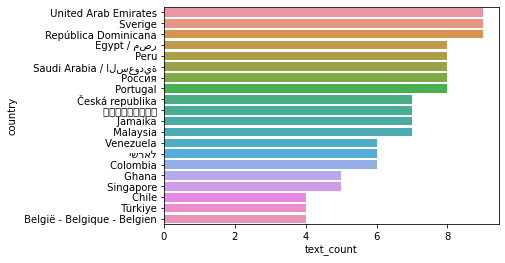

In [0]:
sns.barplot(x="text_count", y="country", data=ciudades_con_un_solo_twit_TOP10)